In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
from collections import Counter

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
data_dir = "../data/"

# Kaggle Data

In [4]:
data_dir = "../data/kaggle/"

In [47]:
train_data = pd.read_csv(data_dir + "train_sessions.csv", usecols=["site" + str(i) for i in range(1,11)] + ["user_id"])

test_df = pd.read_csv(data_dir + "test_sessions.csv", usecols=["site" + str(i) for i in range(1,11)])
test_df.fillna(0, inplace=True)

In [49]:
train_df = pd.DataFrame(columns = train_data.columns, dtype=int)
valid_df = pd.DataFrame(columns = train_data.columns, dtype=int)

In [51]:
for user in Counter(train_data.user_id):
    num_rows = len(train_data[train_data.user_id == user])
    train_user = train_data[train_data.user_id == user].iloc[:int(num_rows * 0.75)]
    valid_user = train_data[train_data.user_id == user].iloc[int(num_rows * 0.75):]
    
    train_df = train_df.append(train_user)
    valid_df = valid_df.append(valid_user)

train_df.fillna(0, inplace=True)
valid_df.fillna(0, inplace=True)
    
train_df = train_df.sample(frac=1).reset_index(drop=True)
valid_df = train_df.sample(frac=1).reset_index(drop=True)

In [62]:
site_dic = pickle.load(open(data_dir + "site_dic.pkl", 'rb'))

# end kaggle data

In [6]:
!ls {data_dir}

checkpoints	  test		     train_sessions.csv
dispoSite	  test_sessions.csv  valid
site_indexes.txt  train		     valid_sessions.csv


In [7]:
site_dic = pd.read_csv(data_dir + "site_indexes.txt", header=None, index_col=0).to_dict("dict")[1]

In [8]:
train_df = pd.read_csv(data_dir + "train_sessions.csv")
valid_df = pd.read_csv(data_dir + "valid_sessions.csv")
test_df = pd.read_csv(data_dir + "test_sessions.csv")

# End Data

In [54]:
train_sites = train_df[["site" + str(i) for i in range(1,11)]].as_matrix()
train_users = train_df["user_id"].as_matrix()

valid_sites = valid_df[["site" + str(i) for i in range(1,11)]].as_matrix()
valid_users = valid_df["user_id"].as_matrix()

test_sites = test_df[["site" + str(i) for i in range(1,11)]].as_matrix()
#test_users = test_df["user_id"].as_matrix()

In [56]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
train_users_vecs = lb.fit_transform(train_users)
valid_users_vecs = lb.transform(valid_users)
#test_users_vecs = lb.transform(test_users)

In [57]:
num_users = train_users_vecs.shape[1]
sess_len = train_sites.shape[1]

In [58]:
num_users, sess_len

(400, 10)

In [59]:
lstm_size = 1024
lstm_layers = 2
batch_size = 64
learning_rate = 0.001
# Size of the embedding vectors (number of units in the embedding layer)
embed_size = 512
num_hidden_units = 256

In [60]:
# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.int32, shape=[None, sess_len], name="inputs")
    labels_ = tf.placeholder(tf.int32, shape=[None, num_users], name="labels")
    keep_prob = tf.placeholder(tf.float32, shape=None, name="keep_prob")

In [65]:
n_sites = len(site_dic)

with graph.as_default():
    embedding = tf.Variable(tf.random_uniform([n_sites, embed_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embedding, inputs_)

In [66]:
with graph.as_default():
    # Your basic LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    
    # Add dropout to the cell
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
     
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

In [67]:
with graph.as_default():
    outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state=initial_state)

In [68]:
with graph.as_default():
    hidden = tf.contrib.layers.fully_connected(outputs[:, -1], num_hidden_units,
                                          weights_initializer = tf.truncated_normal_initializer(stddev=0.01),
                                               biases_initializer=tf.zeros_initializer())
    
    logits = tf.contrib.layers.fully_connected(hidden, num_users, activation_fn=None,
                                          weights_initializer = tf.truncated_normal_initializer(stddev=0.01),
                                               biases_initializer=tf.zeros_initializer())
    
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
    cost = tf.reduce_mean(cross_entropy)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [69]:
with graph.as_default():    
    # Operations for validation/test accuracy
    predicted = tf.nn.softmax(logits)
    correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [70]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [ ]:
%%time
epochs = 10

loss_ar = []
acc_ar = []
val_acc = 0

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 0
    n_batches = len(train_sites)//batch_size
    for e in range(epochs):
        state = sess.run(initial_state)
        
        for ii, (x, y) in enumerate(get_batches(train_sites, train_users_vecs, batch_size), 1):
            iteration +=1
            feed = {inputs_: x,
                    labels_: y,
                    keep_prob: 0.5,
                    initial_state: state}
            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
            loss_ar.append(loss)
            
            if iteration%100==0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Batch: {}/{}".format(ii, n_batches),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))

            if iteration%1000==0:
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(valid_sites, valid_users_vecs, batch_size):
                    feed = {inputs_: x,
                            labels_: y,
                            keep_prob: 1,
                            initial_state: val_state}
                    val_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
            acc_ar.append(val_acc)
    saver.save(sess, data_dir + "checkpoints/identifyme.ckpt")

Epoch: 0/10 Batch: 100/4279 Iteration: 100 Train loss: 5.569
Epoch: 0/10 Batch: 200/4279 Iteration: 200 Train loss: 5.439
Epoch: 0/10 Batch: 300/4279 Iteration: 300 Train loss: 5.311
Epoch: 0/10 Batch: 400/4279 Iteration: 400 Train loss: 5.451
Epoch: 0/10 Batch: 500/4279 Iteration: 500 Train loss: 5.083
Epoch: 0/10 Batch: 600/4279 Iteration: 600 Train loss: 4.890
Epoch: 0/10 Batch: 700/4279 Iteration: 700 Train loss: 5.095
Epoch: 0/10 Batch: 800/4279 Iteration: 800 Train loss: 5.503
Epoch: 0/10 Batch: 900/4279 Iteration: 900 Train loss: 5.169
Epoch: 0/10 Batch: 1000/4279 Iteration: 1000 Train loss: 4.954
Val acc: 0.047
Epoch: 0/10 Batch: 1100/4279 Iteration: 1100 Train loss: 5.033
Epoch: 0/10 Batch: 1200/4279 Iteration: 1200 Train loss: 4.916
Epoch: 0/10 Batch: 1300/4279 Iteration: 1300 Train loss: 4.647
Epoch: 0/10 Batch: 1400/4279 Iteration: 1400 Train loss: 4.546
Epoch: 0/10 Batch: 1500/4279 Iteration: 1500 Train loss: 5.302
Epoch: 0/10 Batch: 1600/4279 Iteration: 1600 Train loss: 4

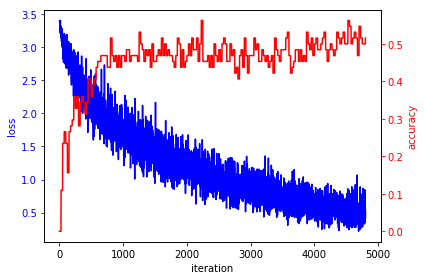

In [71]:
fig, ax1 = plt.subplots()
t = np.linspace(0, iteration, iteration)
ax1.plot(t, loss_ar, 'b-')
ax1.set_xlabel('iteration')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('loss', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(t, acc_ar, 'r-')
ax2.set_ylabel('accuracy', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

# Testing

In [72]:
test_acc = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint(data_dir + 'checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(test_sites, test_users_vecs, batch_size), 1):
        feed = {inputs_: x,
                labels_: y,
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))

Test accuracy: 0.368
